# SIIM-ACR Pneumothorax – YOLO11 Segmentation Explorer

Use this notebook to rebuild the processed YOLO dataset, inspect random training examples, and run quick sanity checks on trained weights. The heavy lifting is handled by the utilities in `src/`.

In [4]:
from pathlib import Path
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from src.dataset_prep import DatasetConfig, Yolo11SegmentationDatasetBuilder
from src import paths

paths.ensure_directories()
plt.style.use('ggplot')


In [5]:
# Rebuild (or reuse) the processed YOLO dataset
config = DatasetConfig()
builder = Yolo11SegmentationDatasetBuilder(config)
dataset_yaml = builder.prepare()
dataset_yaml


Indexing DICOM files: 10712it [01:10, 152.38it/s]
Processing test: 100%|██████████| 1377/1377 [00:26<00:00, 51.08it/s]


WindowsPath('D:/GitHub/SIIM-ACR-Pneumothorax-Yolo11-Segmentation/data/processed/yolo11/dataset.yaml')

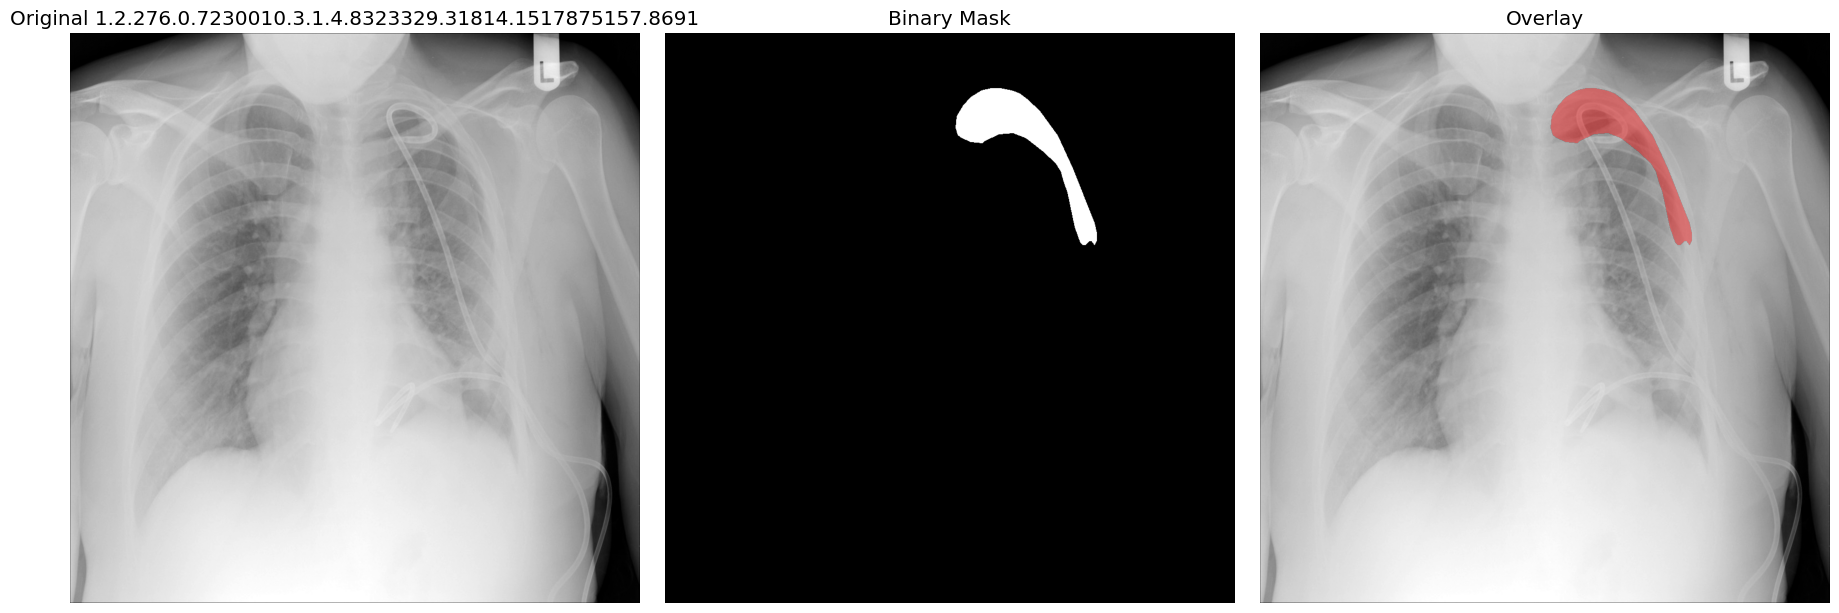

In [6]:
def yolo_labels_to_mask(label_path: Path, width: int, height: int) -> np.ndarray:
    mask = np.zeros((height, width), dtype=np.uint8)
    if not label_path.exists():
        return mask
    with open(label_path, 'r', encoding='utf-8') as handle:
        for line in handle:
            parts = line.strip().split()
            if len(parts) < 7:
                continue
            coords = np.array([float(v) for v in parts[1:]], dtype=np.float32).reshape(-1, 2)
            coords[:, 0] *= width
            coords[:, 1] *= height
            polygon = coords.astype(np.int32)
            cv2.fillPoly(mask, [polygon], 1)
    return mask

def sample_training_example(subset: str = 'train'):
    images_dir = paths.PROCESSED_DIR / 'images' / subset
    labels_dir = paths.PROCESSED_DIR / 'labels' / subset

    positive_ids = []
    for label_file in labels_dir.glob('*.txt'):
        if label_file.read_text(encoding='utf-8').strip():
            positive_ids.append(label_file.stem)
    if not positive_ids:
        raise RuntimeError('No positive masks were found in the processed dataset.')
    image_id = random.choice(positive_ids)
    image = np.array(Image.open(images_dir / f'{image_id}.png').convert('L'))
    mask = yolo_labels_to_mask(labels_dir / f'{image_id}.txt', image.shape[1], image.shape[0])
    return image_id, image, mask

image_id, image, mask = sample_training_example('train')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title(f'Original {image_id}')
axes[0].axis('off')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Binary Mask')
axes[1].axis('off')
axes[2].imshow(image, cmap='gray')
axes[2].imshow(np.ma.masked_where(mask == 0, mask), alpha=0.4, cmap='autumn')
axes[2].set_title('Overlay')
axes[2].axis('off')
plt.tight_layout()
plt.show()


In [7]:
# Optional: run inference with trained weights once available
weights_dir = paths.PROJECT_ROOT / 'artifacts' / 'runs'
best_weights = next(weights_dir.glob('**/weights/best.pt'), None) if weights_dir.exists() else None
if best_weights is not None:
    from ultralytics import YOLO
    test_dir = paths.PROCESSED_DIR / 'images' / 'test'
    sample_image = next(test_dir.glob('*.png'))
    model = YOLO(best_weights)
    result = model.predict(source=sample_image.as_posix(), imgsz=1024, conf=0.25, device='0', verbose=False)[0]
    mask = result.masks.data.cpu().numpy().sum(axis=0) > 0.5 if result.masks is not None else None
    plt.figure(figsize=(6, 6))
    plt.imshow(Image.open(sample_image).convert('L'), cmap='gray')
    if mask is not None:
        plt.imshow(np.ma.masked_where(~mask, mask), alpha=0.4, cmap='autumn')
    plt.title(f'Inference preview: {sample_image.stem}')
    plt.axis('off')
else:
    print('No trained weights found yet. Train a model with src/train.py first.')


No trained weights found yet. Train a model with src/train.py first.
